In [23]:
!ls


drive  sample_data  train


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir train
!mkdir train/128

In [0]:
!cp '/content/drive/My Drive/kaggle/bengali/input/grapheme-imgs-128x128.zip' train
!cp '/content/drive/My Drive/kaggle/bengali/input/train_with_fold.csv' train
#!cp '/content/drive/My Drive/kaggle/bengali/output/w_mishdense_eps36_sr02_bs32_adam_cw_fold1.h5' train

In [0]:
!unzip train/grapheme-imgs-128x128.zip  -d train/128/

In [24]:
!ls train

128  grapheme-imgs-128x128.zip	train_with_fold.csv


In [0]:
%tensorflow_version 2.x

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2
import math

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau,LambdaCallback
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from sklearn.utils import class_weight
from tensorflow.python.client import device_lib


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [27]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3839415736432237975, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13492446846365825705
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8200746225780437786
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15500336154889652849
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
train_dir='./train/128'

In [0]:
dataset_np = pd.read_csv('./train/train_with_fold.csv').to_numpy()
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]
fold = 3

valid_m = np.where(dataset_np[:,6]==fold)[0].shape[0]
train_m = dataset_m-valid_m

fold_train_inds = np.where(dataset_np[:,6] != fold)
fold_valid_inds = np.where(dataset_np[:,6] == fold)

train_np = dataset_np[fold_train_inds]
valid_np = dataset_np[fold_valid_inds]

train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)

train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

train_df.drop(columns=[5,6], inplace=True)
valid_df.drop(columns=[5,6], inplace=True)

In [0]:
cons_unique=np.unique(train_np[:,3])
cons_y_train = train_np[:,3]
vowel_unique=np.unique(train_np[:,2])
vowel_y_train = train_np[:,2]
root_unique =np.unique(train_np[:,1])
root_y_train = train_np[:,1]

cons_class_weights = class_weight.compute_class_weight('balanced',
                                                 cons_unique,
                                                 cons_y_train)

vowel_class_weights = class_weight.compute_class_weight('balanced',
                                                 vowel_unique,
                                                 vowel_y_train)

root_class_weights = class_weight.compute_class_weight('balanced',
                                                 root_unique,
                                                 root_y_train)
cons_cw_dict=dict(enumerate(cons_class_weights))
vowel_cw_dict=dict(enumerate(vowel_class_weights))
root_cw_dict=dict(enumerate(root_class_weights))

model_cw={}
model_cw['root']=root_cw_dict
model_cw['vowel']=vowel_cw_dict
model_cw['consonant']=cons_cw_dict

In [0]:
class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

In [0]:
class BetaMish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(BetaMish, self).__init__(activation, **kwargs)
        self.__name__ = 'BetaMish'


def betamish(inputs, beta=1.5):
    return inputs * tf.math.tanh(tf.math.log(tf.math.pow(1 + tf.math.exp(inputs), beta)))

get_custom_objects().update({'BetaMish': BetaMish(betamish)})

In [0]:
backbone = DenseNet121(include_top=False, weights=None, input_shape=(128, 128, 3))

In [0]:
def build_head(x_in, n, name=None):
  x = layers.GlobalAveragePooling2D()(x_in)
  x = Activation('BetaMish', name='bmish_act1_'+name) (x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(512)(x)
  x = Activation('BetaMish', name='bmish_act2_'+name) (x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(n, name=name, activation='softmax')(x)
  return x

In [0]:
def build_model(backbone):
    x_in = layers.Input(shape=(128, 128, 3))
    x = backbone(x_in)
    out_root = build_head(x, 168,'root')
    out_vowel = build_head(x, 11,'vowel')
    out_consonant = build_head(x,7,'consonant')
    
    model = tf.keras.Model(inputs=x_in, outputs=[out_root, out_vowel, out_consonant])
    
    return model
  

In [0]:
model = build_model(backbone)

In [0]:
for (n, layer) in enumerate(model.layers[1].layers):
  if 'activation' in layer.get_config() and layer.get_config()['activation'] == 'relu':
        layer.activation = BetaMish(betamish)
        

In [0]:
import tempfile

def apply_modifications(model, custom_objects=None):
    """Applies modifications to the model layers to create a new Graph. For example, simply changing
    `model.layers[idx].activation = new activation` does not change the graph. The entire graph needs to be updated
    with modified inbound and outbound tensors because of change in layer building function.
    Args:
        model: The `keras.models.Model` instance.
    Returns:
        The modified model with changes applied. Does not mutate the original `model`.
    """
    # The strategy is to save the modified model and load it back. This is done because setting the activation
    # in a Keras layer doesnt actually change the graph. We have to iterate the entire graph and change the
    # layer inbound and outbound nodes with modified tensors. This is doubly complicated in Keras 2.x since
    # multiple inbound and outbound nodes are allowed with the Graph API.
    model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
    try:
        model.save(model_path)
        return load_model(model_path, custom_objects=custom_objects)
    finally:
        os.remove(model_path)

In [38]:
model = apply_modifications(model, custom_objects={'betamish':BetaMish(betamish)})

In [0]:
loss_dict={'root': 'categorical_crossentropy',
           'vowel':    'categorical_crossentropy',
           'consonant':'categorical_crossentropy'}
           
metrics_dict={ 'root':     [tf.keras.metrics.Recall(name='recall')],
               'vowel':    [tf.keras.metrics.Recall(name='recall')],
              'consonant': [tf.keras.metrics.Recall(name='recall')]}

#metrics_dict={ 'root':     ['accuracy'],
#               'vowel':    ['accuracy'],
#               'consonant':['accuracy']}


model.compile(optimizer='adam', loss=loss_dict, loss_weights=[2.0,1.0,1.0], 
                  metrics=metrics_dict)

In [0]:
train_datagen = ImageDataGenerator(rotation_range = 10,
                                   shear_range = 0.1)

valid_datagen = ImageDataGenerator() 

In [41]:
columns=["root_class","vowel_class", "cons_class"]
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_dir,
        x_col="filename",
        y_col=columns,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode="multi_output",
        colormode="greyscale")

valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=train_dir,
        x_col="filename",
        y_col=columns,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode="multi_output",
        colormode="greyscale")

Found 160672 validated image filenames.
Found 40168 validated image filenames.


In [0]:
def split_into_3_outputs(y_batch):
    
    y1=tf.keras.utils.to_categorical(y_batch[0],168)
    y2=tf.keras.utils.to_categorical(y_batch[1],11)
    y3=tf.keras.utils.to_categorical(y_batch[2],7)
    
    return y1,y2,y3

In [0]:
def aux_data_gen(generator):
    stats = (0.0692, 0.2051)
    while True:
        batch = next(generator)
        batch_x = (batch[0].astype(np.float32)/255.0 - stats[0])/stats[1]
        yield batch_x, split_into_3_outputs(batch[1])

In [0]:
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0, epoch_offset=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose
        self.epoch_offset = epoch_offset

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * (epoch + self.epoch_offset) / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [0]:
#model.load_weights('train/w_mishdense_eps30_sr02_bs32_adam_cw_fold4.h5')

In [46]:
epochs = 10

ca_shed = CosineAnnealingScheduler(T_max=36, eta_max=1e-3, eta_min=1e-6,verbose=1, epoch_offset=0)

history=model.fit_generator(aux_data_gen(train_generator),
                    validation_data=aux_data_gen(valid_generator),
                    epochs=epochs,
                    steps_per_epoch=train_m//batch_size+1,
                    validation_steps = valid_m//batch_size+1,
                    callbacks=[ca_shed],
                    class_weight=model_cw)

history.history['weighted_recall']= 0.5*np.array(history.history['root_recall'])+0.25*np.array(history.history['consonant_recall'])+0.25*np.array(history.history['vowel_recall'])
history.history['val_weighted_recall']= 0.5*np.array(history.history['val_root_recall'])+0.25*np.array(history.history['val_consonant_recall'])+0.25*np.array(history.history['val_vowel_recall'])

model.save_weights('/content/drive/My Drive/kaggle/bengali/output/w_betamish_d121_eps10_sr02_bs32_adam_cw_fold'+str(fold)+'.h5')
model.save('/content/drive/My Drive/kaggle/bengali/output/m_betamish_d121_eps10_sr02_bs32_adam_cw_fold'+str(fold)+'.h5')
pd.DataFrame(history.history).to_csv('/content/drive/My Drive/kaggle/bengali/output/h_betamish_d121_eps10_sr02_bs32_adam_cw_fold'+str(fold)+'.csv', index=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Train for 5022 steps, validate for 1256 steps

Epoch 00001: CosineAnnealingScheduler setting learning rate to 0.001.
Epoch 1/10
5022/5022 [==============================] - 1114s 222ms/step - loss: 7.4023 - root_loss: 2.8895 - vowel_loss: 0.7990 - consonant_loss: 0.8241 - root_recall: 0.1540 - vowel_recall: 0.6607 - consonant_recall: 0.5795 - val_loss: 5.1310 - val_root_loss: 1.8672 - val_vowel_loss: 0.5622 - val_consonant_loss: 0.8344 - val_root_recall: 0.3443 - val_vowel_recall: 0.7756 - val_consonant_recall: 0.8330

Epoch 00002: CosineAnnealingScheduler setting learning rate to 0.000998099251696827.
Epoch 2/10
5022/5022 [==============================] - 1088s 217ms/step - loss: 2.7543 - root_loss: 1.0154 - vowel_loss: 0.3431 - consonant_loss: 0.3804 - root_recall: 0.5652 - vowel_recall: 0.8562 - consonant_recall: 0.8146 - val_loss: 1.4440 - val_root_loss: 0.5229 - val_vowel_loss: 0.1921 - val_consonant_loss

InvalidArgumentError: ignored

In [0]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 2.9007483e-06,
 'name': 'Adam'}

In [0]:
from matplotlib import pyplot as plt

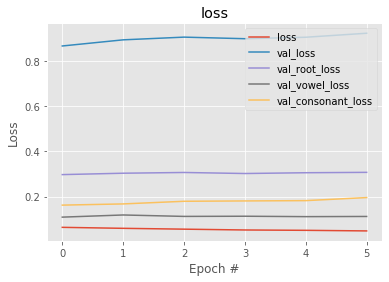

In [0]:
%matplotlib inline

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label='loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, epochs), history.history['val_root_loss'], label='val_root_loss')
plt.plot(np.arange(0, epochs), history.history['val_vowel_loss'], label='val_vowel_loss')
plt.plot(np.arange(0, epochs), history.history['val_consonant_loss'], label='val_consonant_loss')

    
plt.title('loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

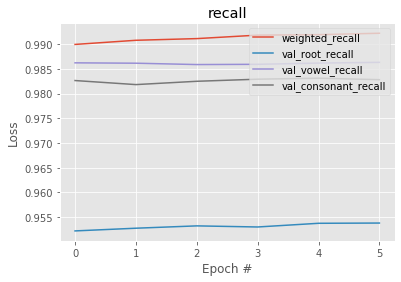

In [0]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['weighted_recall'], label='weighted_recall')
plt.plot(np.arange(0, epochs), history.history['val_root_recall'], label='val_root_recall')
plt.plot(np.arange(0, epochs), history.history['val_vowel_recall'], label='val_vowel_recall')
plt.plot(np.arange(0, epochs), history.history['val_consonant_recall'], label='val_consonant_recall')

    
plt.title('recall')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

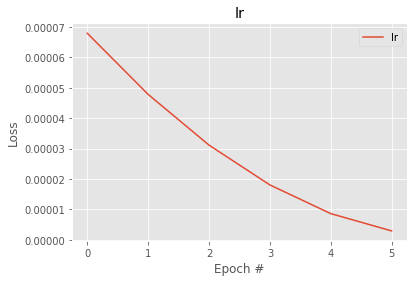

In [0]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['lr'], label='lr')

    
plt.title('lr')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

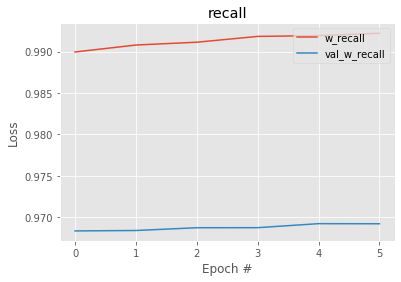

In [0]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['weighted_recall'], label='w_recall')
plt.plot(np.arange(0, epochs), history.history['val_weighted_recall'], label='val_w_recall')
    
plt.title('recall')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()